In [40]:
from src.data.get_dataset import get_merged_datasets
dataframe = get_merged_datasets()
dataframe.shape

(3104, 234)

In [41]:
numeric_cols = dataframe.select_dtypes(include=['number']).columns.difference(['year']).tolist() #we don't want year to be a feature in our prediction model
#we want to limit our feature set to columns without any data leaks, since in real prediction we wouldn't know those values.
data_leak_list = ["co2", "ghg", "greenhouse_gas",  "change"]
possible_data_leak_list = ["nitrous_oxide", "methane", "ch4", "n2o"]
to_exclude = data_leak_list + possible_data_leak_list

def is_data_leak(s, to_exclude):
    for data_leak in to_exclude:
        if data_leak in s:
            return True

    return False

feature_list = []
for x in numeric_cols:
    is_leak = is_data_leak(x, to_exclude)
    if not is_leak:
        feature_list.append(x)

print(feature_list)

['agricultural_land_area_in_hectares', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'carbon_intensity_elec', 'coal_cons_per_capita', 'coal_consumption', 'coal_elec_per_capita', 'coal_electricity', 'coal_prod_per_capita', 'coal_share_elec', 'coal_share_energy', 'cropland_area_in_hectares', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_per_capita', 'energy_per_gdp', 'forest_land_area_in_hectares', 'fossil_elec_per_capita', 'fossil_electricity', 'fossil_energy_per_capita', 'fossil_share_elec', 'fossil_share_energy', 'gas_consumption', 'gas_elec_per_capita', 'gas_electricity', 'gas_energy_per_capita', 'gas_prod_per_capita', 'gas_production', 'gas_share_elec', 'gas_share_energy', 'gdp', 'hydro_consumption', 'hydro_elec_per_capita', 'hydro_electricity', 'hydro_energy_per_capita', 'hydro_share_elec', 'hydro_share_energy', 'low_carbon_consumption', 'low_car

In [42]:
#checking correlations between various features and co2 data
dataframe[feature_list + ['co2']].corr()['co2'].sort_values(ascending=False) #Reduced feature list to 97, need to check if any of these are unrelated. 

co2                                                                           1.000000
fossil_electricity                                                            0.990392
primary_energy_consumption                                                    0.987325
electricity_generation                                                        0.979712
electricity_demand                                                            0.979417
                                                                                ...   
population_ages_00-04,_female_(%_of_female_population)_[sp.pop.0004.fe.5y]   -0.161173
population_ages_10-14,_female_(%_of_female_population)_[sp.pop.1014.fe.5y]   -0.163258
nuclear_share_energy                                                         -0.164459
population_ages_05-09,_female_(%_of_female_population)_[sp.pop.0509.fe.5y]   -0.166384
oil_share_energy                                                             -0.174311
Name: co2, Length: 125, dtype: float64

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ('std_scalar', StandardScaler())])
# test if I can hand-pick a few features avoiding most of the repeats.
X = dataframe[feature_list]
y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Training Model for features with no data leaks

In [45]:
X_train_no_data_leaks = data_pipeline.fit_transform(X_train)
X_test_no_data_leaks = data_pipeline.transform(X_test)
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models_no_data_leaks = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train_no_data_leaks, y_train) for x in models_no_data_leaks ] #train features with data leak features removed

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [46]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def adjusted_r2(r2_score, sample_size, num_features):
    return 1-(1-r2_score)*(sample_size-1)/(sample_size-num_features-1)

## Checking scores for models with data leak features removed.

In [47]:
training_predictions = [m.predict(X_train_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_no_data_leaks)]

Train data scores
 LinearRegression: Mean Squared Error: 291.2595120797233, R2_score 0.9994291749086471, Adjusted R2 score: 0.9993991569649119, Mean absolute Percentage Error: 256.7621650351169%
 Ridge: Mean Squared Error: 292.07327509117573, R2_score 0.9994275800548275, Adjusted R2 score: 0.9993974782426132, Mean absolute Percentage Error: 200.38142956341574%
 Lasso: Mean Squared Error: 458.89086912550283, R2_score 0.9991006425149204, Adjusted R2 score: 0.9990533480585378, Mean absolute Percentage Error: 102.24352650298785%
 DecisionTreeRegressor: Mean Squared Error: 0.0, R2_score 1.0, Adjusted R2 score: 1.0, Mean absolute Percentage Error: 0.0%
 RandomForestRegressor: Mean Squared Error: 369.2671911476501, R2_score 0.9992762915222395, Adjusted R2 score: 0.9992382339093293, Mean absolute Percentage Error: 2.9555388663801927%
 SGDRegressor: Mean Squared Error: 799.8065480421332, R2_score 0.9984324987617029, Adjusted R2 score: 0.9983500686711394, Mean absolute Percentage Error: 265.8362

[None, None, None, None, None, None]

In [48]:
predictions = [m.predict(X_test_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_test, y_) for y_ in predictions]
r2_scores = [r2_score(y_test, y_) for y_ in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Test data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_no_data_leaks)]

Test data scores
 LinearRegression: Mean Squared Error: 392.7532702549642, R2_score 0.9996311526901713, Adjusted R2 score: 0.9995389408627142, Mean absolute Percentage Error: 248.9161197250124%
 Ridge: Mean Squared Error: 361.53560647364304, R2_score 0.9996604702087687, Adjusted R2 score: 0.9995755877609609, Mean absolute Percentage Error: 232.64525573640128%
 Lasso: Mean Squared Error: 512.6824389841931, R2_score 0.9995185233256162, Adjusted R2 score: 0.9993981541570203, Mean absolute Percentage Error: 94.86515728937677%
 DecisionTreeRegressor: Mean Squared Error: 4170.215149012881, R2_score 0.9960836159604182, Adjusted R2 score: 0.9951045199505227, Mean absolute Percentage Error: 10.464542237669344%
 RandomForestRegressor: Mean Squared Error: 820.3945454427925, R2_score 0.999229540925558, Adjusted R2 score: 0.9990369261569476, Mean absolute Percentage Error: 7.5852407775204%
 SGDRegressor: Mean Squared Error: 1468.6407782438762, R2_score 0.9986207519040943, Adjusted R2 score: 0.99827

[None, None, None, None, None, None]

In [49]:
#random forest has the lowest accuracy error and a decent r2 score.
random_forest_preds = predictions[4]

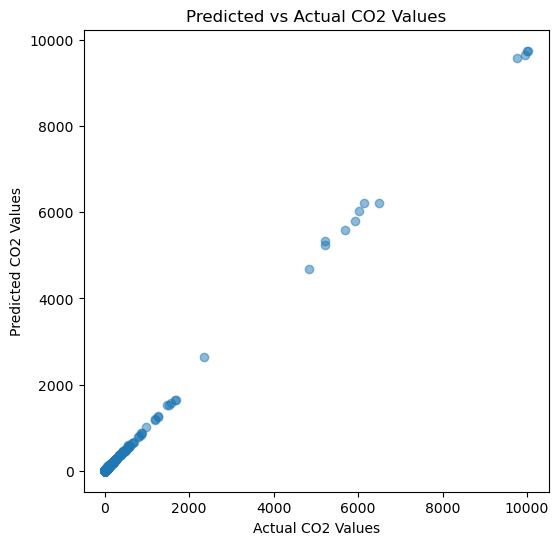

In [50]:
#Seems like Lasso performs the best which is to be expected.

import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, random_forest_preds, alpha=0.5)
plt.xlabel('Actual CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Predicted vs Actual CO2 Values')
plt.show()

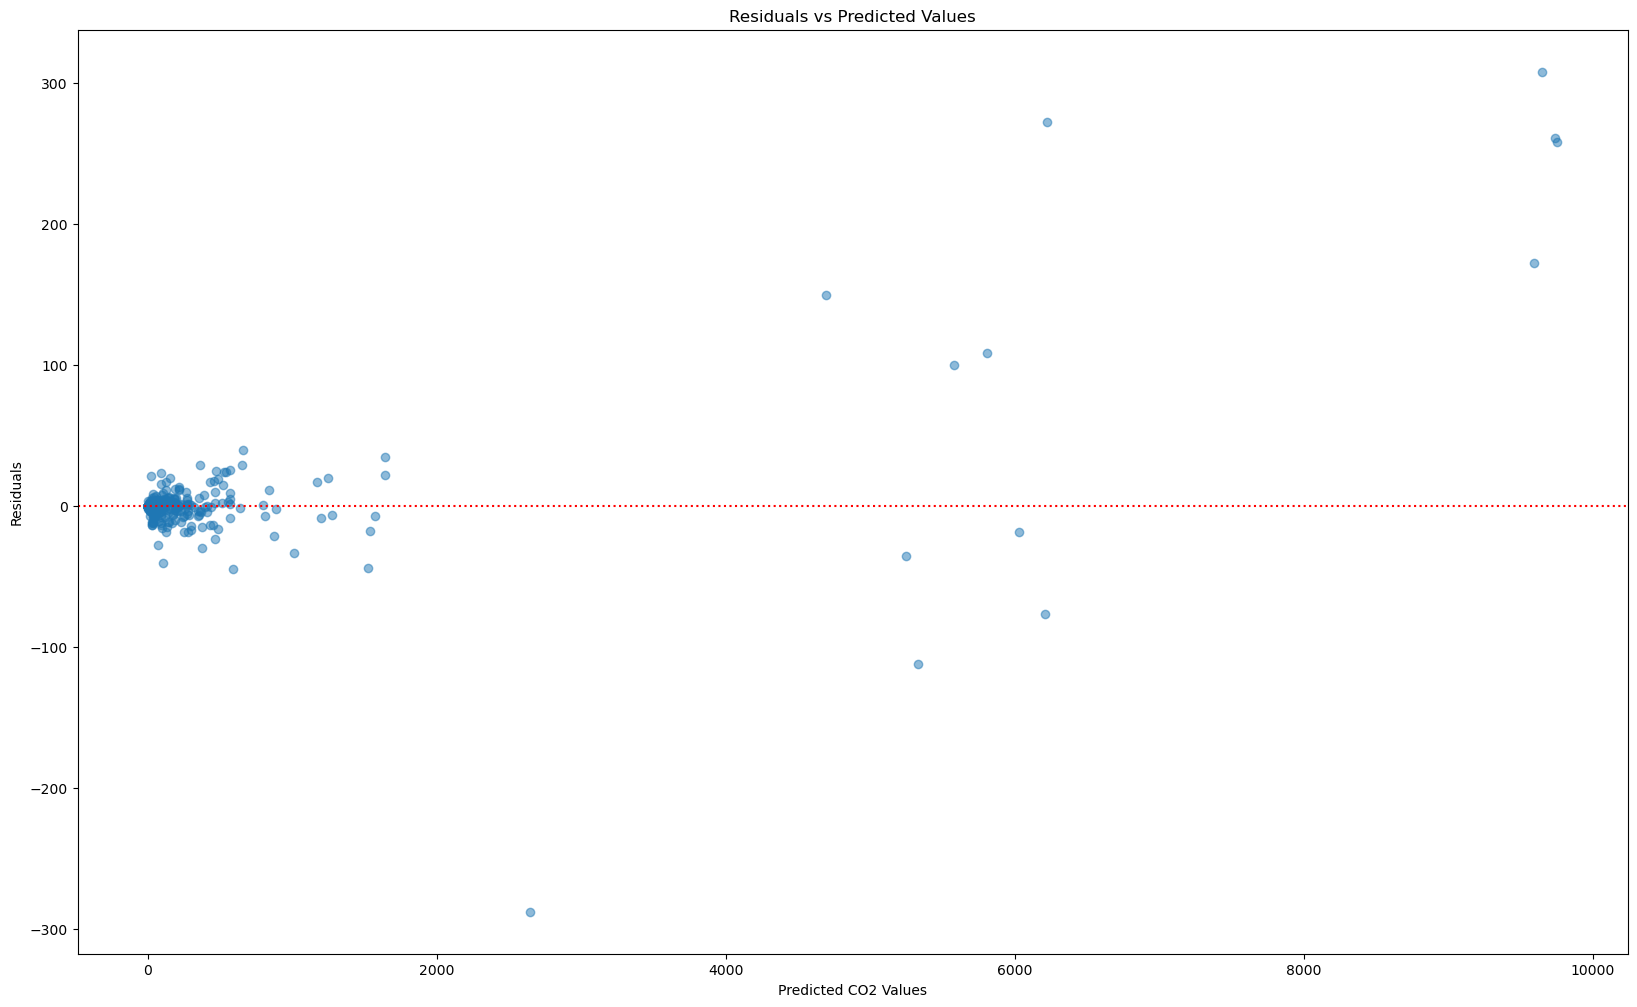

In [51]:
# Assuming you have your actual and predicted values as follows:
actual_values = y_test
predicted_values = random_forest_preds

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting the residuals
plt.figure(figsize=(20, 12))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted CO2 Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle=':')  # Adds a horizontal line at zero
plt.show()

<Axes: >

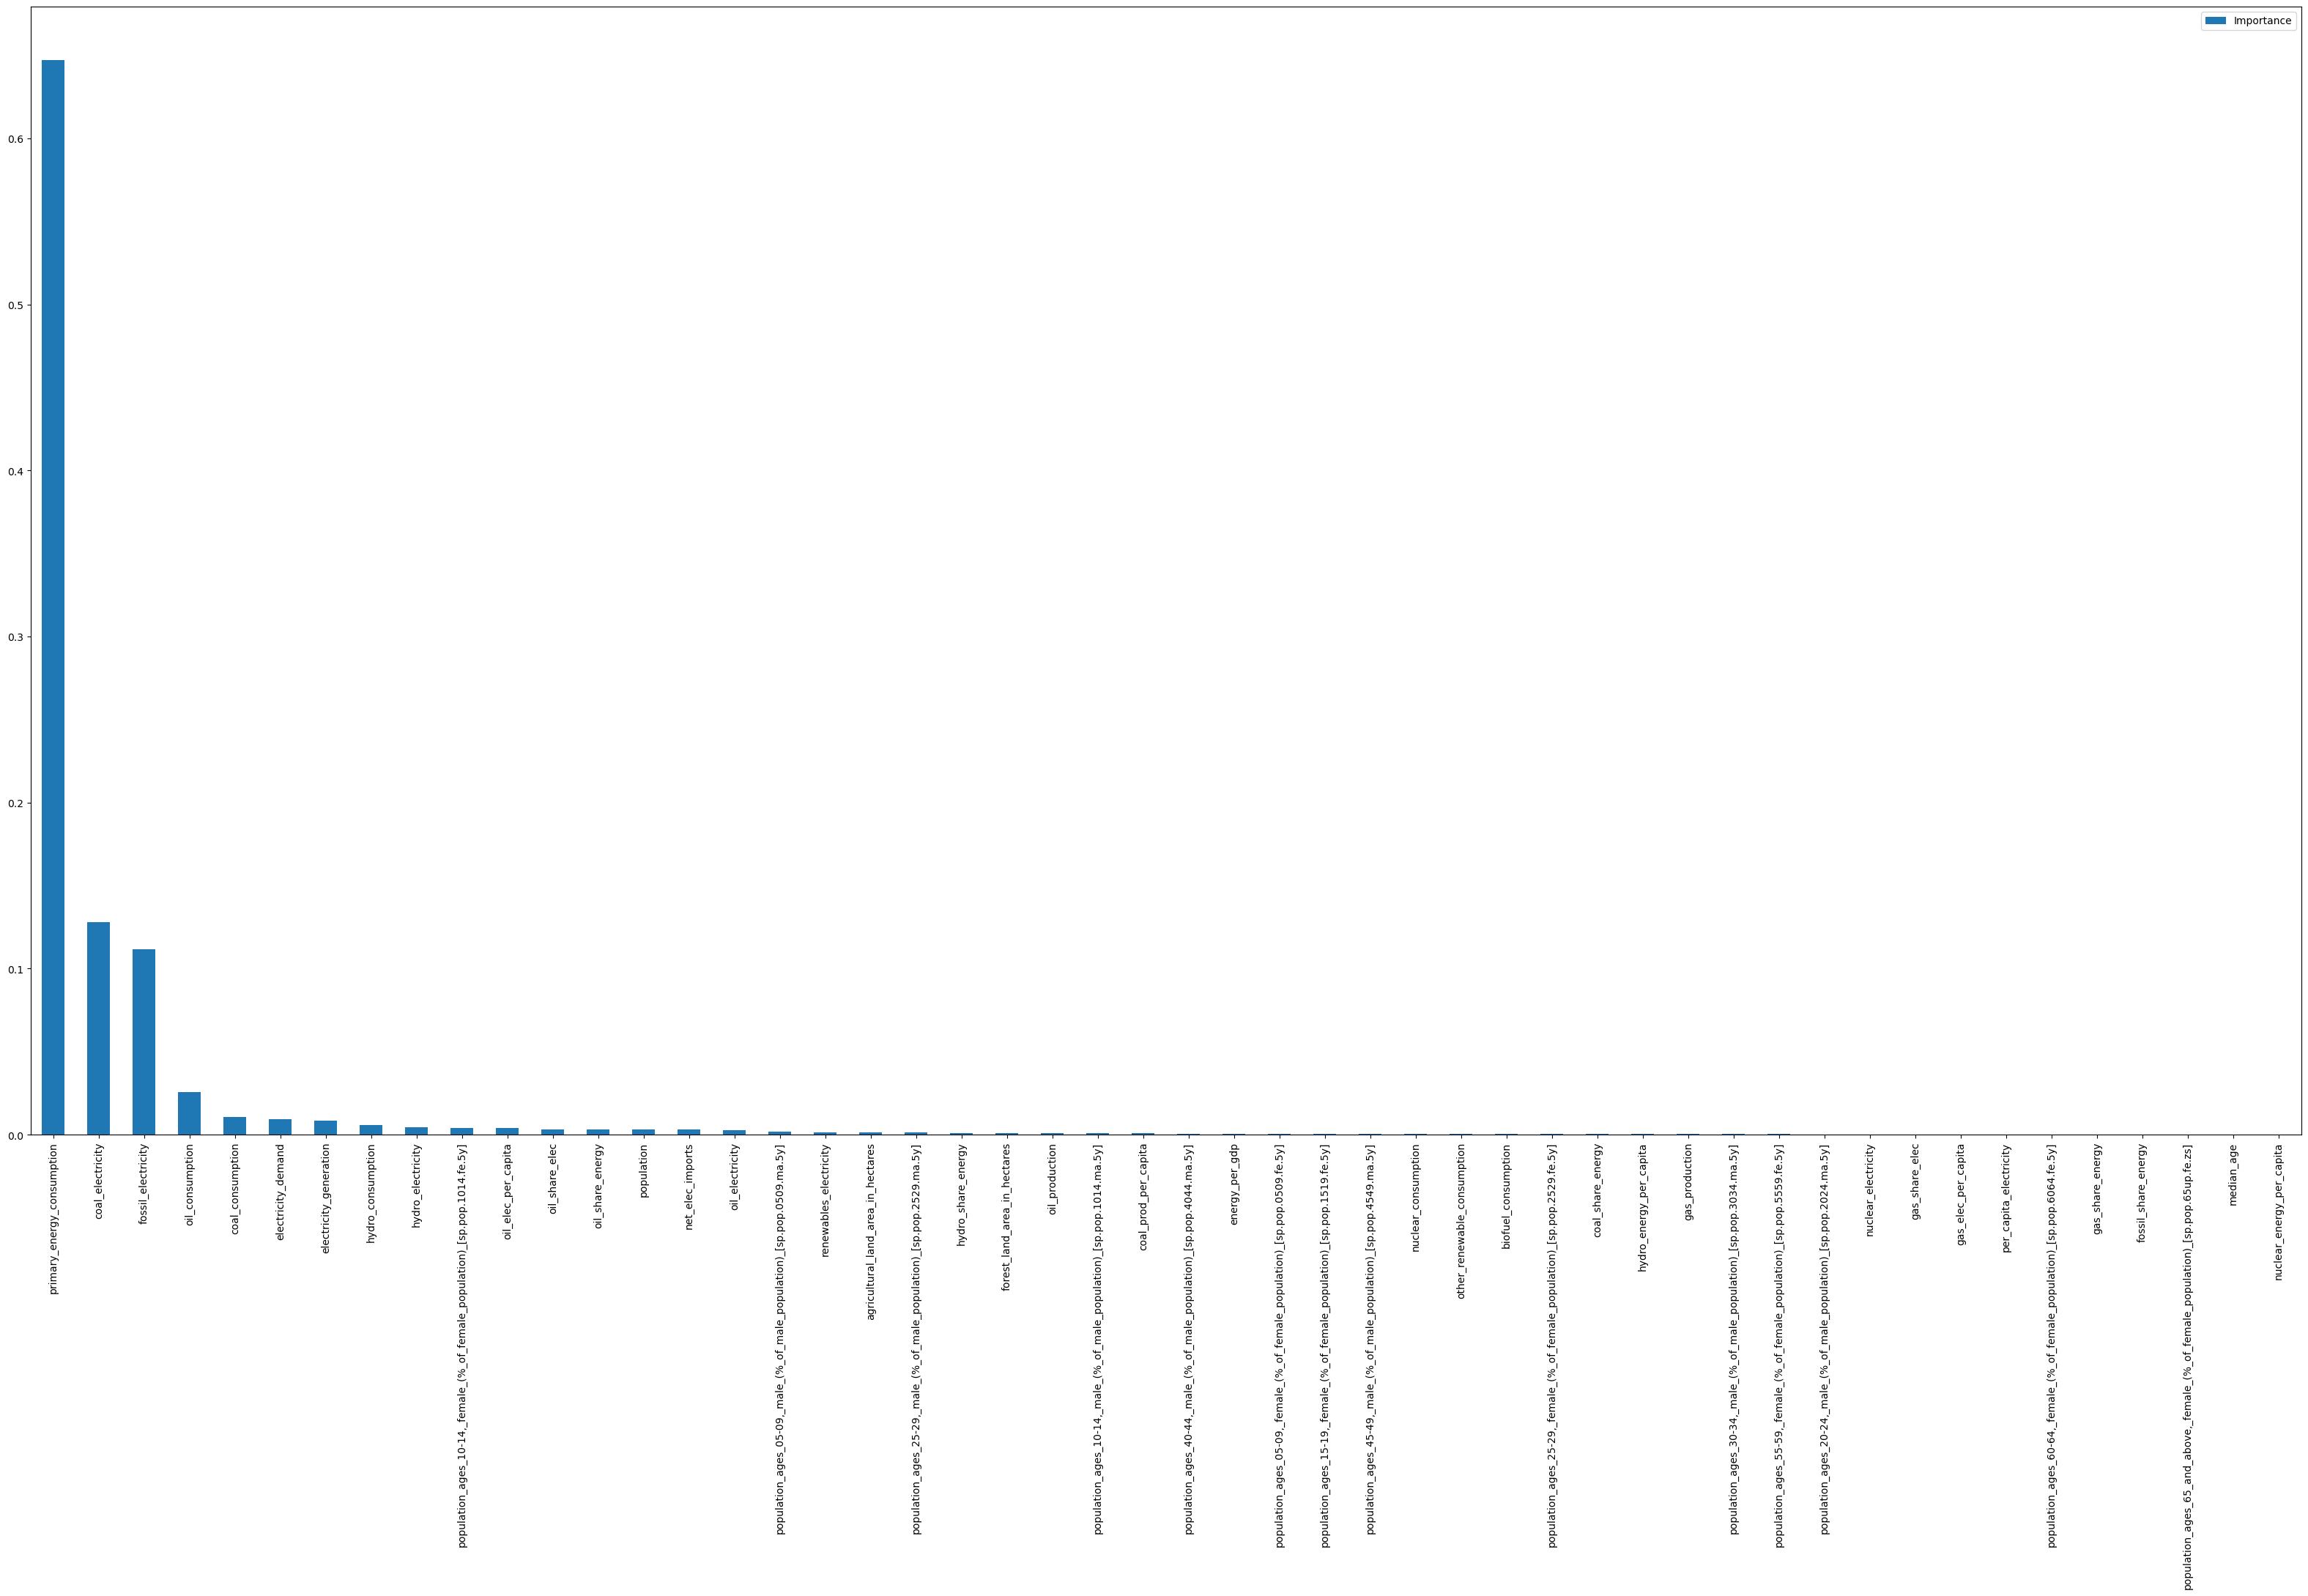

In [57]:
import pandas as pd
model = models_no_data_leaks[4]
importance_df = pd.DataFrame(model.feature_importances_, index=feature_list, columns=["Importance"])
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df.head(50).plot(kind='bar', figsize=(40,20))

In [53]:
selected_features = importance_df.head(20).index.tolist()
print(selected_features)

X = dataframe[selected_features]
y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = data_pipeline.fit_transform(X_train)
X_test = data_pipeline.transform(X_test)

['primary_energy_consumption', 'fossil_electricity', 'oil_electricity', 'oil_prod_per_capita', 'oil_production', 'oil_energy_per_capita', 'population_ages_55-59,_male_(%_of_male_population)_[sp.pop.5559.ma.5y]', 'wind_share_energy', 'population_ages_00-04,_female_(%_of_female_population)_[sp.pop.0004.fe.5y]', 'fossil_energy_per_capita', 'agricultural_land_area_in_hectares', 'biofuel_electricity', 'oil_share_elec', 'population', 'electricity_generation', 'population_ages_50-54,_male_(%_of_male_population)_[sp.pop.5054.ma.5y]', 'gas_production', 'coal_cons_per_capita', 'population_ages_30-34,_female_(%_of_female_population)_[sp.pop.3034.fe.5y]', 'population_ages_35-39,_male_(%_of_male_population)_[sp.pop.3539.ma.5y]']


In [54]:
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train, y_train) for x in models ]

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [55]:
training_predictions = [m.predict(X_train) for m in models]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models)]

Train data scores
 LinearRegression: Mean Squared Error: 2014.7913018523554, R2_score 0.9960513103221089, Adjusted R2 score: 0.9960192332329303, Mean absolute Percentage Error: 220.2384648603095%
 Ridge: Mean Squared Error: 2035.476251769916, R2_score 0.9960107709133116, Adjusted R2 score: 0.9959783645031841, Mean absolute Percentage Error: 231.17745111520964%
 Lasso: Mean Squared Error: 2564.0672893123096, R2_score 0.9949748115204701, Adjusted R2 score: 0.9949339895181993, Mean absolute Percentage Error: 228.99365660315866%
 DecisionTreeRegressor: Mean Squared Error: 0.0, R2_score 1.0, Adjusted R2 score: 1.0, Mean absolute Percentage Error: 0.0%
 RandomForestRegressor: Mean Squared Error: 431.1247003262126, R2_score 0.9991550600538642, Adjusted R2 score: 0.9991481962037738, Mean absolute Percentage Error: 3.0457453989653627%
 SGDRegressor: Mean Squared Error: 4010.8748337230686, R2_score 0.9921392850759905, Adjusted R2 score: 0.9920754287402959, Mean absolute Percentage Error: 460.142

[None, None, None, None, None, None]

In [56]:
predictions = [m.predict(X_test) for m in models]
mean_sq_errors = [mean_squared_error(y_test, y) for y in predictions]
r2_scores = [r2_score(y_test, y) for y in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100} %") for i, model in enumerate(models)]

Train data scores
 LinearRegression: Mean Squared Error: 3131.0612569892205, R2_score 0.9970595190186463, Adjusted R2 score: 0.9969615029859346, Mean absolute Percentage Error: 245.77063534899378 %
 Ridge: Mean Squared Error: 2913.307965586922, R2_score 0.9972640181834475, Adjusted R2 score: 0.9971728187895623, Mean absolute Percentage Error: 259.8431417444822 %
 Lasso: Mean Squared Error: 2924.4414655248115, R2_score 0.9972535623532557, Adjusted R2 score: 0.9971620144316975, Mean absolute Percentage Error: 249.82499759168962 %
 DecisionTreeRegressor: Mean Squared Error: 2857.4430628083724, R2_score 0.9973164827220377, Adjusted R2 score: 0.9972270321461055, Mean absolute Percentage Error: 10.211308617299064 %
 RandomForestRegressor: Mean Squared Error: 2337.843658781257, R2_score 0.9978044553422009, Adjusted R2 score: 0.9977312705202742, Mean absolute Percentage Error: 8.125175393601609 %
 SGDRegressor: Mean Squared Error: 4280.753210501448, R2_score 0.9959798060886703, Adjusted R2 sco

[None, None, None, None, None, None]